# Some experiments on PGN data

### Imports

In [3]:
import os
import time
import chess
import numpy as np
import matplotlib.pyplot as plt
import chess.pgn

### Parsing 50k games

In [4]:
start = time.time()

pgn = open('../data/fics_202011_notime_50k.pgn')

def doNothing():
    return

while chess.pgn.read_game(pgn):
    doNothing()

end = time.time()
print(f'Time elapsed: {end - start}')

Time elapsed: 198.99153566360474


### Calculating relative value of pieces for a given colour

In [5]:
# [pawn, knight, bishop, rook, queen], see https://en.wikipedia.org/wiki/Chess_piece_relative_value
piece_values = [1, 3, 3, 5, 9]

# Given chess.Board and chess.Color
# Returns sum of piece values for that color
def get_piece_value(board, color):
    piece_value_sum = 0
    for i in range(0, 5):
        piece_value_sum += piece_values[i] * len(board.pieces(i+1, color))
    return piece_value_sum

In [6]:
pgn = open('../data/fics_202011_notime_50k.pgn')

game = chess.pgn.read_game(pgn)
board = game.board()
get_piece_value(board, chess.BLACK)

39

### Game metadata

In [7]:
game.headers

Headers(Event='FICS rated blitz game', Site='FICS freechess.org', Date='2020.11.30', Round='?', White='stevharr', Black='nimzoii', Result='1-0', BlackClock='0:05:00.000', BlackElo='1337', BlackRD='0.0', ECO='B32', FICSGamesDBGameNo='474470039', PlyCount='117', Time='23:49:00', TimeControl='300+0', WhiteClock='0:05:00.000', WhiteElo='1677', WhiteRD='0.0')

In [8]:
# Given chess.pgn.Game and chess.Color
# Return -1 if draw, 1 if color won, 0 if color lost.
def get_game_result(game, color):
    if '1/2' in game.headers['Result']:
        return -1
    elif color == chess.WHITE:
        return game.headers['Result'][0]
    else:
        return game.headers['Result'][2]

In [9]:
white_elo = game.headers['WhiteElo']
black_elo = game.headers['BlackElo']
    
print(f'White Elo: {white_elo}, Black Elo: {black_elo}')
print(f'Result for white: {get_game_result(game, chess.WHITE)}')

White Elo: 1677, Black Elo: 1337
Result for white: 1


PlyCount:  108
White Elo: 1012, Black Elo: 1553
Result for white: 0














































































































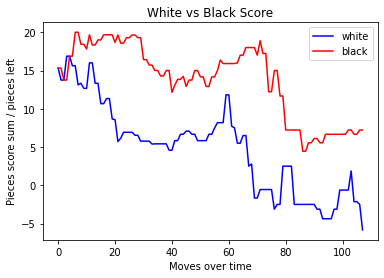

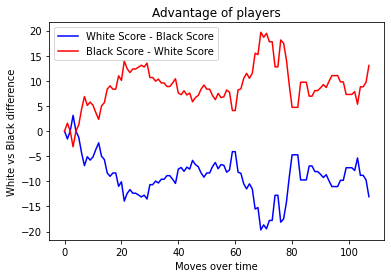

In [17]:
#https://www.chessprogramming.org/Simplified_Evaluation_Function#Piece-Square_Tables

pawn_weights_w = np.array([
    [0,  0,  0,  0,  0,  0,  0,  0],
    [50, 50, 50, 50, 50, 50, 50, 50],
    [10, 10, 20, 30, 30, 20, 10, 10],
    [5,  5, 10, 25, 25, 10,  5,  5],
    [0,  0,  0, 20, 20,  0,  0,  0],
    [5, -5,-10,  0,  0,-10, -5,  5],
    [5, 10, 10,-20,-20, 10, 10,  5],
    [0,  0,  0,  0,  0,  0,  0,  0]
])
pawn_weights_b = np.flipud(pawn_weights_w)
    
knight_weights_w = np.array([
    [-50,-40,-30,-30,-30,-30,-40,-50],
    [-40,-20,  0,  0,  0,  0,-20,-40],
    [-30,  0, 10, 15, 15, 10,  0,-30],
    [-30,  5, 15, 20, 20, 15,  5,-30],
    [-30,  0, 15, 20, 20, 15,  0,-30],
    [-30,  5, 10, 15, 15, 10,  5,-30],
    [-40,-20,  0,  5,  5,  0,-20,-40],
    [-50,-40,-30,-30,-30,-30,-40,-50]
])
knight_weights_b = np.flipud(knight_weights_w)

bishop_weights_w = np.array([
    [-20,-10,-10,-10,-10,-10,-10,-20],
    [-10,  0,  0,  0,  0,  0,  0,-10],
    [-10,  0,  5, 10, 10,  5,  0,-10],
    [-10,  5,  5, 10, 10,  5,  5,-10],
    [-10,  0, 10, 10, 10, 10,  0,-10],
    [-10, 10, 10, 10, 10, 10, 10,-10],
    [-10,  5,  0,  0,  0,  0,  5,-10],
    [-20,-10,-10,-10,-10,-10,-10,-20]  
])
bishop_weights_b = np.flipud(bishop_weights_w)

rook_weights_w = np.array([
    [0,  0,  0,  0,  0,  0,  0,  0],
    [5, 10, 10, 10, 10, 10, 10,  5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [-5,  0,  0,  0,  0,  0,  0, -5],
    [0,  0,  0,  5,  5,  0,  0,  0]   
])
rook_weights_b = np.flipud(rook_weights_w)

queen_weights_w = np.array([
    [-20,-10,-10, -5, -5,-10,-10,-20],
    [-10,  0,  0,  0,  0,  0,  0,-10],
    [-10,  0,  5,  5,  5,  5,  0,-10],
    [-5,  0,  5,  5,  5,  5,  0, -5],
    [0,  0,  5,  5,  5,  5,  0, -5],
    [-10,  5,  5,  5,  5,  5,  0,-10],
    [-10,  0,  5,  0,  0,  0,  0,-10],
    [-20,-10,-10, -5, -5,-10,-10,-20]  
])
queen_weights_b = np.flipud(queen_weights_w)

king_weights_mid_w = np.array([
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-20,-30,-30,-40,-40,-30,-30,-20],
    [-10,-20,-20,-20,-20,-20,-20,-10],
    [20, 20,  0,  0,  0,  0, 20, 20],
    [20, 30, 10,  0,  0, 10, 30, 20]
])
king_weights_mid_b = np.flipud(king_weights_mid_w)

king_weights_late_w = np.array([
    [-50,-40,-30,-20,-20,-30,-40,-50],
    [-30,-20,-10,  0,  0,-10,-20,-30],
    [-30,-10, 20, 30, 30, 20,-10,-30],
    [-30,-10, 30, 40, 40, 30,-10,-30],
    [-30,-10, 30, 40, 40, 30,-10,-30],
    [-30,-10, 20, 30, 30, 20,-10,-30],
    [-30,-30,  0,  0,  0,  0,-30,-30],
    [-50,-30,-30,-30,-30,-30,-30,-50] 
])
king_weights_late_b = np.flipud(king_weights_late_w)

weights_w = [pawn_weights_w, knight_weights_w, bishop_weights_w,
            rook_weights_w, queen_weights_w, king_weights_mid_w, king_weights_late_w]

weights_b = [pawn_weights_b, knight_weights_b, bishop_weights_b,
            rook_weights_b, queen_weights_b, king_weights_mid_b, king_weights_late_b]


def evalPiece(piece, i, j, moveNum):

    if piece == None:
        return
    weights = []
    if piece.color == chess.WHITE:
        weights = weights_w
    elif piece.color == chess.BLACK:
        weights = weights_b
    else:
        print("Invalid color")
        return 0
    # possible also to add functionality for late game / mid game king positions. for different matrices
    
    pt = piece.piece_type
    #print("Piece type: ", pt)
    #print("i: ", i)
    #print("j: ", j)
    #print("Score: ", weights[pt-1][i][j])
    if pt == 6:
        if moveNum > limit:
            return weights[pt][i][j]
    return weights[pt-1][i][j]
    
def getBoardValue(board, color):
    if color == chess.BLACK or color == chess.WHITE:
        sum_of_weights = 0
        count = 0
        for i in range(7,-1,-1):
            for j in range(7,-1,-1):
                res =0
                piece = board.piece_at(chess.SQUARES[i * 8 + j])
                moveNum = board.fullmove_number
                if  piece != None and piece.color == color:
                    res = evalPiece(piece, i, j, moveNum)
                    count += 1
                if res != None:
                    sum_of_weights += res
        return sum_of_weights / count
        #return sum_of_weights # can possibly add normalisation based on score / pieces left for given color
    else:
        print("Invalid color")
        return
    

pgn = open('../data/fics_202011_notime_50k.pgn')

historyw = []
historyb = []
game = chess.pgn.read_game(pgn)
game = chess.pgn.read_game(pgn)

totalMoves = game.headers['PlyCount']
print("PlyCount: ", totalMoves)
limit = int(totalMoves) * 0.66


white_elo = game.headers['WhiteElo']
black_elo = game.headers['BlackElo']
print(f'White Elo: {white_elo}, Black Elo: {black_elo}')
print(f'Result for white: {get_game_result(game, chess.WHITE)}')

board = game.board()


for move in game.mainline_moves():
    #print(board)
    print('')
    wscore = getBoardValue(board, chess.WHITE)
    bscore = getBoardValue(board, chess.BLACK)
    movNum = board.fullmove_number
    #print("White Score: ",wscore)
    #print('')
    #print("Black Score: ",bscore)
    #print("Full Move Number: ", movNum)
    #print('')
    historyw.append(wscore)
    historyb.append(bscore)
    board.push(move)


advantage_w = [x-y for x, y in zip(historyw, historyb)]
advantage_b = [y-x for x, y in zip(historyw, historyb)]

    
plt.figure(1, figsize=(6, 4))
plt.title("White vs Black Score")
plt.plot(historyw, color = 'blue', label='white')
plt.plot(historyb, color = 'red', label='black')
plt.xlabel("Moves over time")
plt.ylabel("Pieces score sum / pieces left")
plt.legend()

plt.show()

plt.figure(1, figsize=(6, 4))
plt.title("Advantage of players")
plt.plot(advantage_w, color = 'blue', label='White Score - Black Score')
plt.plot(advantage_b, color = 'red', label='Black Score - White Score')
plt.ylabel("White vs Black difference")
plt.xlabel("Moves over time")
plt.legend()

plt.show()




    
        

    

